# Developing the Quantum Circuit and Time evolution of Pointilisim Brush
- Building adjaceny matrix J_ij from distance (`DONE`)
- Encode into Ising Hamiltonian
- Evolve with exp(-i*H*t)
- Measure Expectations <Z_i>
- Map normalised <Z_i> values to RGB

Inputs to general function: dot_positions, coupling_strength, evolution_time

In [1]:
#!pip install qutip
#!pip install qiskit-dynamics

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
# set a parameter to see animations in line
from matplotlib import rc
rc('animation', html='jshtml')

%matplotlib inline

In [3]:
from qiskit import QuantumCircuit,ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter, ParameterVector
import qiskit.qasm3
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis.evolution import SuzukiTrotter

### Build $J_{ij}$ matrix
- Find the distance between points in 2D system.

#### Assumptions
- Assumes all points will be equ-distance from each other to complete check that these are neighbouring qubits.

In [4]:
#import qiskit
#qiskit.__version__

In [5]:
dot_positions = np.array([
    (0.0, 0.0),
    (1.0, 0.0),
])
def J_matrix(dot_pos,coupling_constant,tol = 1.5):
    '''
    Generates the coupling matrix for the system. As a place holder
    the system currently just has a simple multipication between the 
    coupling constant and distance between dots.
    Function takes a tolerance to identify if dots are neighbouring
    otherwise discards the value
    Input:
    -    dot_pos            = Positions of dots in x-y plane[array]
    -    coupling_constant  = J coupling constant[float]
    -    tol                = tolerance for identifying neighbouring dots set at 1.5[float]

    Output
    -    matrix             = J matrix[array]
    '''
    #Generate empty matrix
    N = len(dot_pos)
    matrix = np.zeros((N,N))
    
    #Loop over all positions
    for i in range(N):
        for j in range(i+1,N):
            #Find Difference in positions
            dij = dot_pos[i] - dot_pos[j]
            
            #Checks to see if these are neighbouring states
            if (abs(dij[0]) < tol and dij[1] == 0) or (dij[0] ==0 and abs(dij[1]) < tol):
                d = np.sqrt(dij[0]**2+dij[1]**2)
                
                #Add to matrix
                matrix[i,j]=matrix[j,i]=coupling_constant*d
    return matrix

Jmatrix = J_matrix(dot_positions,2)
print(Jmatrix)


[[0. 2.]
 [2. 0.]]


### Building Hamiltonian $\hat{H~}$
Classical Hamiltonian
$$
H(\sigma) = - \sum_{\left<ij\right>}J_{ij}\sigma_i\sigma_{j}
$$

Hamiltonian of Quantum Ising Model [4].

$$
\hat{H} =  - \sum_{\left< ij \right>} J_{ij}\hat{\sigma}^\mathcal{Z}_i \hat{\sigma}^\mathcal{Z}_j
$$
$\hat{\sigma}^{\mathcal{X},\mathcal{Z}}$ are the Pauli Matrices. $J$ is the exchange constant which varies on the qubits interacting and varies based on distance. The matrix containing the possible values for $J$ was produced above. For now we will just work with just the entanging of the states. We will then add the element which introduces the bias introduced by the colour of the image at the point of the dot.  

### Aim
$J$ will be a matrix (first introduce it as a constant as between neighbouring dots its constant), $t$ will be the time evolution of the circuit. To begin lets just consider the interaction between 2 neighbouring dots such that we can only consider the following term.

Qiskit → Trotterized time evolution OR VQE algorithm package
AerSimulator → Optimization + tranpilation are crucial.

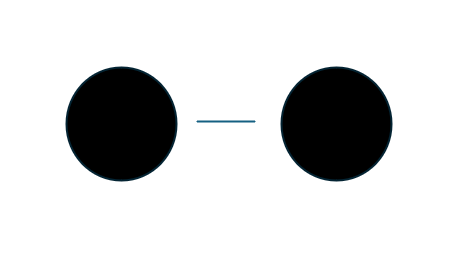

In [6]:
from IPython.display import Image # needed to embed an image
Image(filename='2 qubit Ising System.png', embed=True) # image downloadable from Moodle

In [7]:
dot_positions = np.array([
    (0.0, 0.0),
    (1.0, 0.0)
])
J_C =0.7
Jmatrix = J_matrix(dot_positions,0.7)
print(Jmatrix)


[[0.  0.7]
 [0.7 0. ]]


In [8]:
def Ising_Quantum_Circuit_1D(J,t):
    '''
    Function that generates the Quantum Circuit for a 1D 
    Ising model system. 
    Input:
    -    J  = Coupling Interaction Matrix[array]
    -    t  = Time Evolution[float]

    Output:
    -    qc = Quantum Circuit[obj]
    '''
    N = len(J)
    theta = []
    for i in range(N-1):
        theta_ij = -2*J[i,i+1]*t
        theta.append(theta_ij)

    q = QuantumRegister(N,'q')
    qc = QuantumCircuit(q)
     
    for n in range(N-1):
        qc.rzz(theta[n],n,n+1)
    return qc


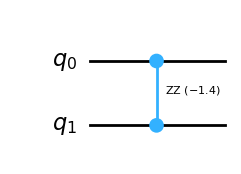

In [9]:
qc = Ising_Quantum_Circuit_1D(Jmatrix,1)

qc.draw("mpl")    

In [10]:
#Find Vector
v = Statevector(qc)
display(v.draw("latex"))

<IPython.core.display.Latex object>

In [11]:
qc.measure_all()

#Transpile Circuit using AerSimulator backend
pm = generate_preset_pass_manager(backend=AerSimulator(),optimization_level=3)
tc = pm.run(qc)

#Initialise 'Sampler' Primitive with 'AerSimulator' backend
sampler = Sampler(mode=AerSimulator())

#Runs Sampler
sj=sampler.run([tc])

#Measures Count
result = sj.result()
print(result[0].data.meas.get_counts())#Only one state so all in state

{'00': 1024}


### Consider 2D Case


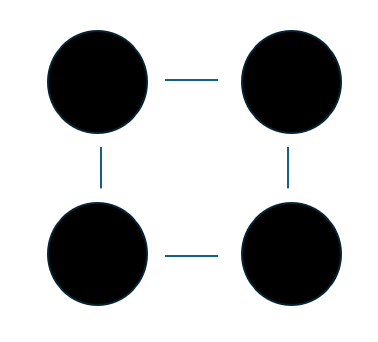

In [12]:
Image(filename='2D Case.png', embed=True)

In [13]:
def Ising_Quantum_Circuit_2D(J,t):
    '''
    Function that generates the Quantum Circuit for a 2D 
    Ising model system. 
    Input:
    -    J  = Coupling Interaction Matrix[array]
    -    t  = Time Evolution[float]

    Output:
    -    qc = Quantum Circuit[obj]
    '''
    N = len(J)
    q = QuantumRegister(N,'q')
    qc = QuantumCircuit(q)
    for i in range(N):
        for j in range(i+1,N):
            if J[i,j] !=0:
                theta_ij = -2*J[i,j]*t
                qc.rzz(theta_ij,i,j)
    return qc


[[0.  0.7 0.7 0. ]
 [0.7 0.  0.  0.7]
 [0.7 0.  0.  0.7]
 [0.  0.7 0.7 0. ]]


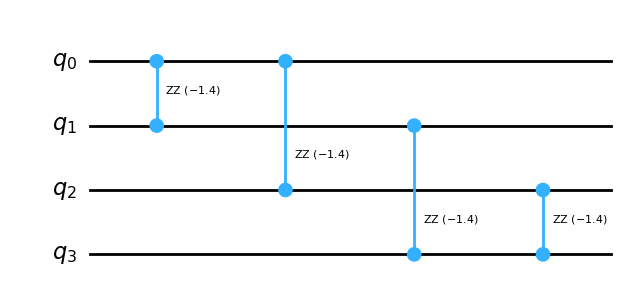

In [14]:
dot_positions = np.array([
    (0.0, 0.0),
    (1.0, 0.0),
    (0.0, 1.0),
    (1.0, 1.0),
])
Jmatrix = J_matrix(dot_positions,0.7)
qc = Ising_Quantum_Circuit_2D(Jmatrix,1)
print(Jmatrix)
qc.draw("mpl")


In [15]:
#Find Vector
v = Statevector(qc)
display(v.draw("latex"))

<IPython.core.display.Latex object>

### 2D Case with 3 rows

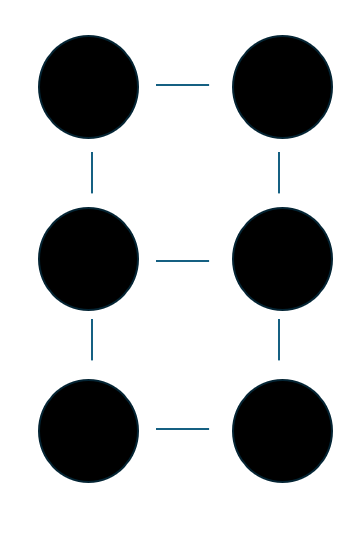

In [16]:
Image(filename='2D Case 3 Rows.png', embed=True)

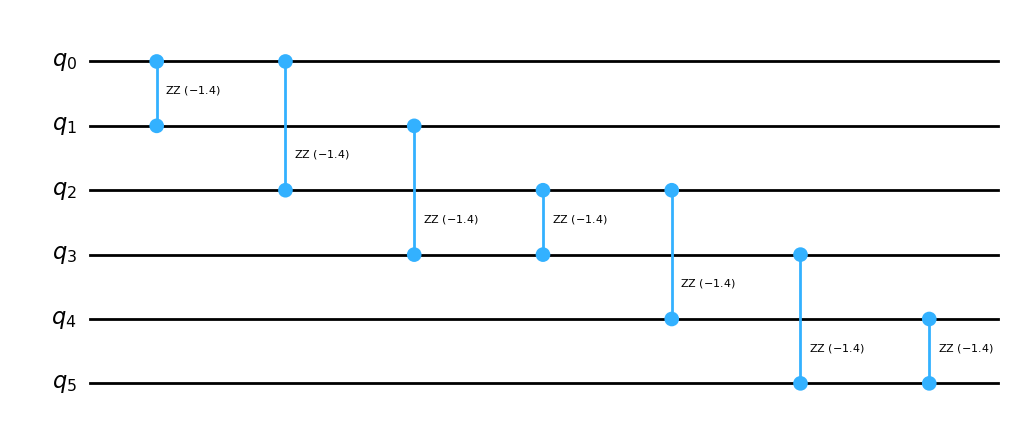

In [17]:
dot_positions = np.array([
    (0.0, 0.0),
    (1.0, 0.0),
    (0.0, 1.0),
    (1.0, 1.0),
    (0.0, 2.0),
    (1.0, 2.0),
])
Jmatrix = J_matrix(dot_positions,0.7)
qc = Ising_Quantum_Circuit_2D(Jmatrix,1) #Expect 2 qubits to have 3 interactions
qc.draw("mpl")  

In [18]:
#Find Vector
v = Statevector(qc)
display(v.draw("latex"))

<IPython.core.display.Latex object>

# 3 x 3 Case


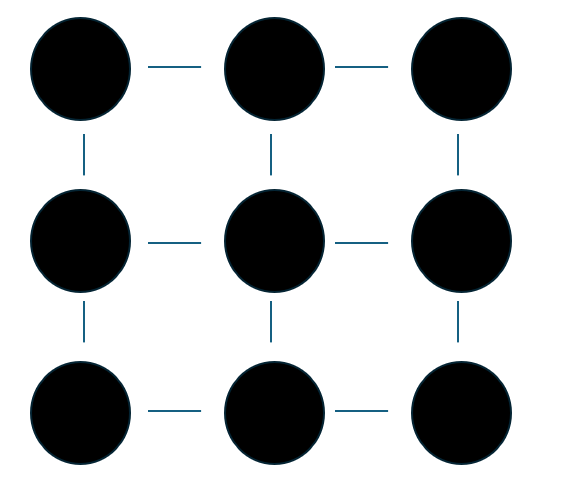

In [19]:
Image(filename='3x3 Case.png', embed=True)

[[0.  0.7 0.  0.7 0.  0.  0.  0.  0. ]
 [0.7 0.  0.7 0.  0.7 0.  0.  0.  0. ]
 [0.  0.7 0.  0.  0.  0.7 0.  0.  0. ]
 [0.7 0.  0.  0.  0.7 0.  0.7 0.  0. ]
 [0.  0.7 0.  0.7 0.  0.7 0.  0.7 0. ]
 [0.  0.  0.7 0.  0.7 0.  0.  0.  0.7]
 [0.  0.  0.  0.7 0.  0.  0.  0.7 0. ]
 [0.  0.  0.  0.  0.7 0.  0.7 0.  0.7]
 [0.  0.  0.  0.  0.  0.7 0.  0.7 0. ]]


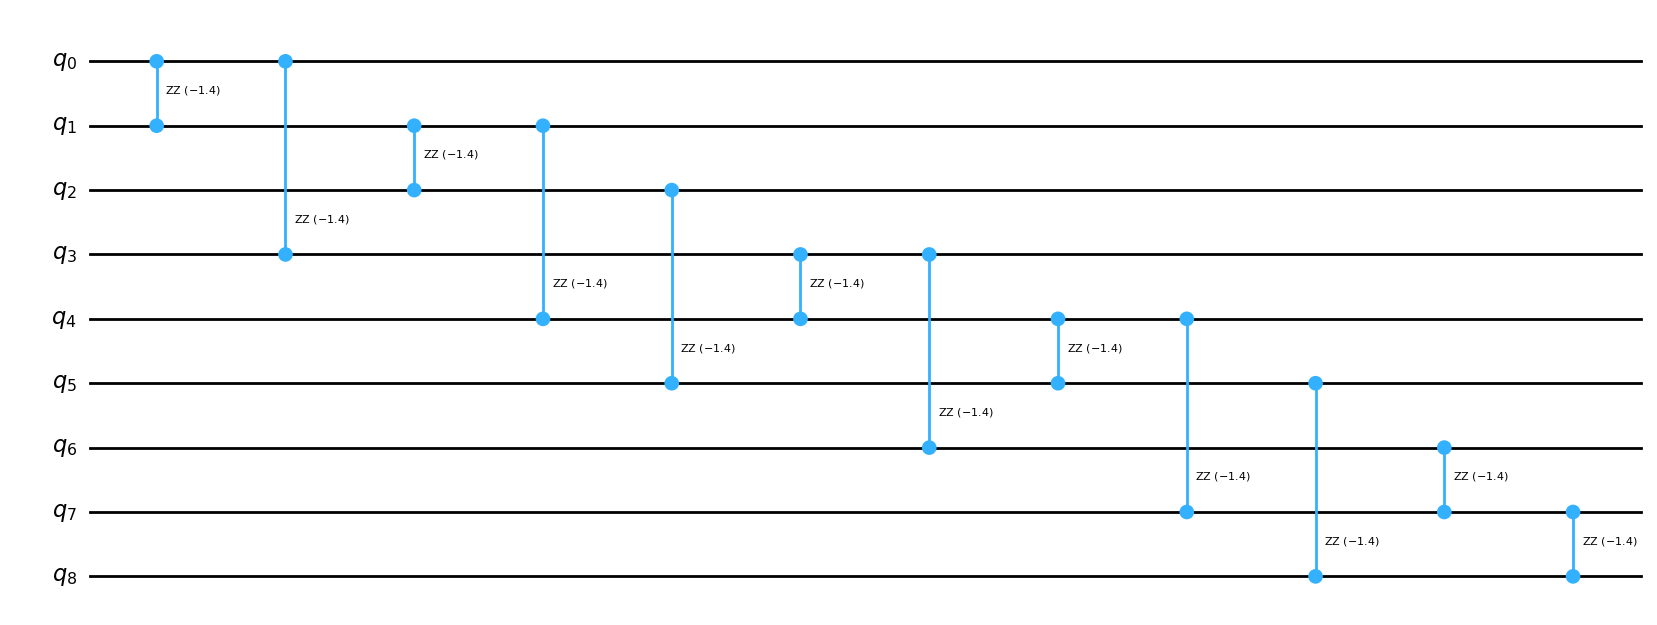

In [20]:
dot_positions = np.array([
    (0.0, 0.0),
    (1.0, 0.0),
    (2.0, 0.0),
    (0.0, 1.0),
    (1.0, 1.0),
    (2.0, 1.0),
    (0.0, 2.0),
    (1.0, 2.0),
    (2.0, 2.0)
])

Jmatrix = J_matrix(dot_positions,0.7)
qc = Ising_Quantum_Circuit_2D(Jmatrix,1) #Expect 1 qubit to have 4 interactions 
print(Jmatrix)
qc.draw("mpl")  

In [21]:
#Find Vector
v = Statevector(qc)
display(v.draw("latex"))

<IPython.core.display.Latex object>

# Results
Generated a circuit that can entangle neighbouring qubits together using the Ising model. It was first proven for two adjacent dots and then built up to a $3\times 3$ grid of dots. As it has been achieved for a $3\times 3$  grid it can be achieved for a $n \times n$ grid.

# References 
[1]https://rajeshrinet.github.io/blog/2014/ising-model/

[2]https://en.wikipedia.org/wiki/Ising_model

[3]https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.RZZGate

[4]Sachdev, S. (2011) Quantum Phase Transitions. Second edition. Vol. 9780521514682. [Online]. Cambridge: Cambridge University Press.

[5]https://quantum.cloud.ibm.com/docs/en/api/qiskit/0.46 qiskit.algorithms.minimum_eigensolvers.VQE

[6]https://qiskit-community.github.io/qiskit-algorithms/tutorials/13_trotterQRTE.html

[7]https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.PauliEvolutionGate

[8]https://quantumcomputing.stackexchange.com/questions/39020/what-is-the-use-of-sparsepauliop-in-qiskit-and-how-to-use-it
